In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import pearsonr

def ReLU(x):
    return np.maximum(0, x)

def ReLU_derivative(x):
    return np.where(x > 0, 1, 0)

# Inicialización de la red neuronal
def initialize_network(n_inputs, n_hidden, n_outputs=1):
    network = {
        'hidden_layer_1': {
            'weights': np.random.randn(n_inputs, n_hidden),
            'biases': np.zeros(n_hidden)
        },
        'hidden_layer_2': {
            'weights': np.random.randn(n_hidden, n_hidden),
            'biases': np.zeros(n_hidden)
        },
        'output_layer': {
            'weights': np.random.randn(n_hidden, n_outputs),
            'biases': np.zeros(n_outputs)
        }
    }
    return network

# Propagación hacia adelante
def forward(network, inputs):
    hidden_inputs_1 = np.dot(inputs, network['hidden_layer_1']['weights']) + network['hidden_layer_1']['biases']
    hidden_outputs_1 = ReLU(hidden_inputs_1)
    
    hidden_inputs_2 = np.dot(hidden_outputs_1, network['hidden_layer_2']['weights']) + network['hidden_layer_2']['biases']
    hidden_outputs_2 = ReLU(hidden_inputs_2)
    
    final_inputs = np.dot(hidden_outputs_2, network['output_layer']['weights']) + network['output_layer']['biases']
    final_outputs = ReLU(final_inputs)
    
    return final_outputs, [hidden_outputs_1, hidden_outputs_2]

# Retropropagación
def backward(network, inputs, outputs, expected_outputs, hidden_outputs):
    expected_outputs = np.array(expected_outputs, ndmin=2)
    output_errors = expected_outputs - outputs
    output_delta  = output_errors * ReLU_derivative(outputs)
    
    hidden_2_errors = np.dot(output_delta, network['output_layer']['weights'].T)
    hidden_2_delta  = hidden_2_errors * ReLU_derivative(hidden_outputs[1])
    
    hidden_1_errors = np.dot(hidden_2_delta, network['hidden_layer_2']['weights'].T)
    hidden_1_delta  = hidden_1_errors * ReLU_derivative(hidden_outputs[0])
    
    l_rate = 0.1
    network['output_layer']['weights']   += l_rate * np.dot(hidden_outputs[1].T, output_delta)
    network['hidden_layer_2']['weights'] += l_rate * np.dot(hidden_outputs[0].T, hidden_2_delta)
    network['hidden_layer_1']['weights'] += l_rate * np.dot(inputs.T, hidden_1_delta)
    
    network['output_layer']['biases']    += l_rate * np.sum(output_delta, axis=0)
    network['hidden_layer_2']['biases']  += l_rate * np.sum(hidden_2_delta, axis=0)
    network['hidden_layer_1']['biases']  += l_rate * np.sum(hidden_1_delta, axis=0)

# Entrenamiento de la red neuronal
def train(network, train_data, l_rate=0.1, n_epochs=20):
    errors = []
    for _ in range(n_epochs):
        total_error = 0
        for row in train_data:
            inputs = np.array(row[0], ndmin=2)
            expected_outputs = np.array(row[1], ndmin=2)
            outputs, hidden_outputs = forward(network, inputs)
            total_error += np.sum((expected_outputs - outputs) ** 2)
            backward(network, inputs, outputs, expected_outputs, hidden_outputs)
        errors.append(total_error)
    return errors

# Visualización de los errores durante el entrenamiento
def plot_errors(errors):
    plt.plot(errors)
    plt.xlabel('Época')
    plt.ylabel('Error Total')
    plt.title('Error a lo largo del entrenamiento')
    plt.show()

# Visualización de las activaciones de las capas ocultas
def plot_activations(activations):
    for i, activation in enumerate(activations):
        plt.figure(figsize=(15, 5))
        plt.matshow(activation, fignum=1, cmap='viridis')
        plt.title(f'Activaciones de la Capa Oculta {i+1}')
        plt.colorbar()
        plt.show()

# Visualización de los pesos de la red
def plot_weights(network):
    for layer, content in network.items():
        plt.figure(figsize=(10, 5))
        plt.title(f'Pesos de {layer}')
        plt.imshow(content['weights'], aspect='auto', cmap='viridis')
        plt.colorbar()
        plt.show()

# Inferencia utilizando la red neuronal entrenada
def predict(network, input_data):
    outputs, _ = forward(network, np.array(input_data, ndmin=2))
    return outputs

# Carga y preparación de datos
def load_and_prepare_data(filepath):
    df = pd.read_csv(filepath)
    max_value = max(df[['open', 'high', 'low','close']].max().to_list())
    normalized_dataset = [(row[['open', 'high', 'low']].tolist(), [row['close']])
                          for index, row in df.iterrows()]
    normalized_dataset = [(np.array(inputs) / max_value, [target[0] / max_value])
                          for inputs, target in normalized_dataset]
    return normalized_dataset, max_value

def split_dataset(dataset, split_ratio=0.8):
    """Divide el conjunto de datos en conjuntos de entrenamiento y validación."""
    split_index = int(len(dataset) * split_ratio)
    return dataset[:split_index], dataset[split_index:]


# Validación de la red
def validate_and_plot(network, validation_data):
    actuals, predictions = [], []
    for inputs, expected in validation_data:
        predicted = predict(network, inputs)
        actuals.append(expected[0])
        predictions.append(predicted[0, 0])
    
    # Calculando métricas de rendimiento
    actuals, predictions = np.array(actuals), np.array(predictions)
    mae = np.mean(np.abs(actuals - predictions))
    mse = np.mean((actuals - predictions) ** 2)
    correlation, _ = pearsonr(actuals.flatten(), predictions.flatten())
    
    # Visualizando la comparación entre los valores reales y los predichos
    plt.figure(figsize=(14, 6))
    plt.subplot(1, 2, 1)
    plt.plot(actuals, label='Actual', marker='o')
    plt.plot(predictions, label='Predicted', marker='x')
    plt.title('Validación: Real vs Predicción')
    plt.xlabel('Muestra')
    plt.ylabel('Valor')
    plt.legend()

    # Visualizando la distribución de los errores
    plt.subplot(1, 2, 2)
    errors = actuals - predictions
    plt.hist(errors, bins=20, color='gray', edgecolor='black')
    plt.title('Distribución de los Errores de Predicción')
    plt.xlabel('Error')
    plt.ylabel('Frecuencia')

    plt.tight_layout()
    plt.show()

    # Imprimiendo las métricas de rendimiento
    print(f'MAE: {mae:.4f}, MSE: {mse:.4f}, Correlación: {correlation:.4f}')


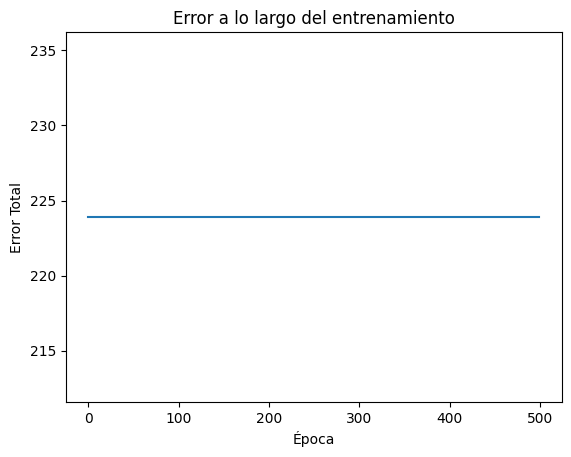

In [2]:
# Carga de datos 
filepath = '/home/jd/Documentos/CODIGO/Machine-Learning/tutorials/ai-from-scratch/resources/btc.csv'
dataset, max_value = load_and_prepare_data(filepath)
train_data, valid_data = split_dataset(dataset)

In [ ]:
# Inicialización de la red neuronal
network = initialize_network(n_inputs=3, n_hidden=3)
errors = train(network, train_data, l_rate=0.01, n_epochs=50)
plot_errors(errors)

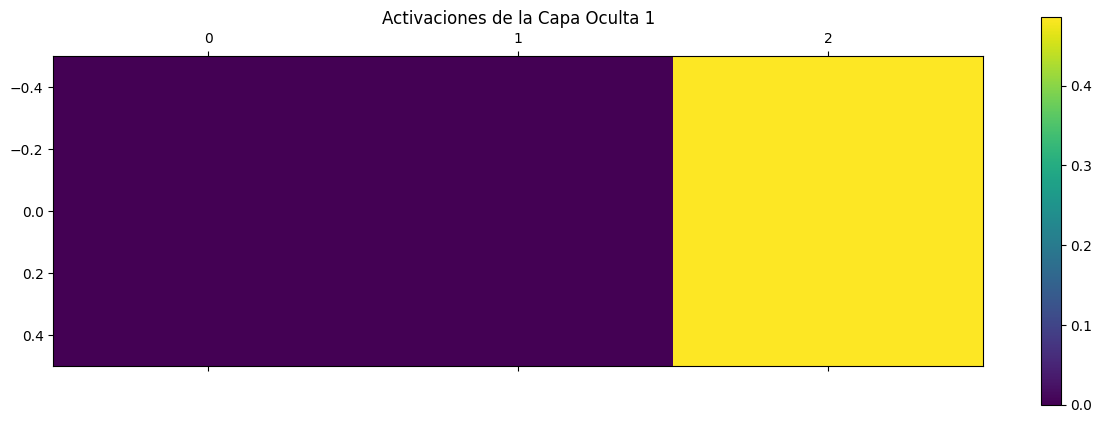

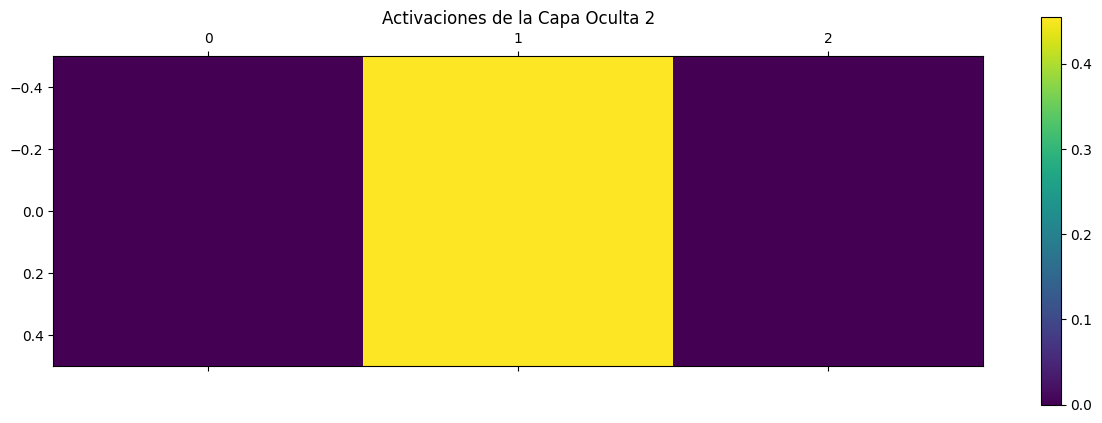

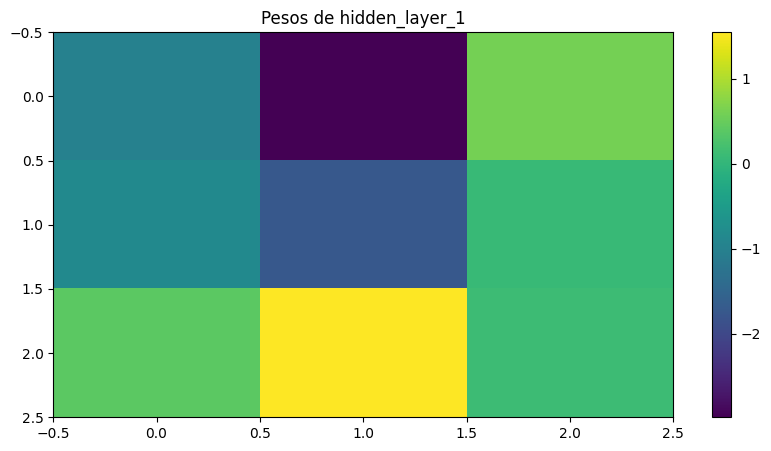

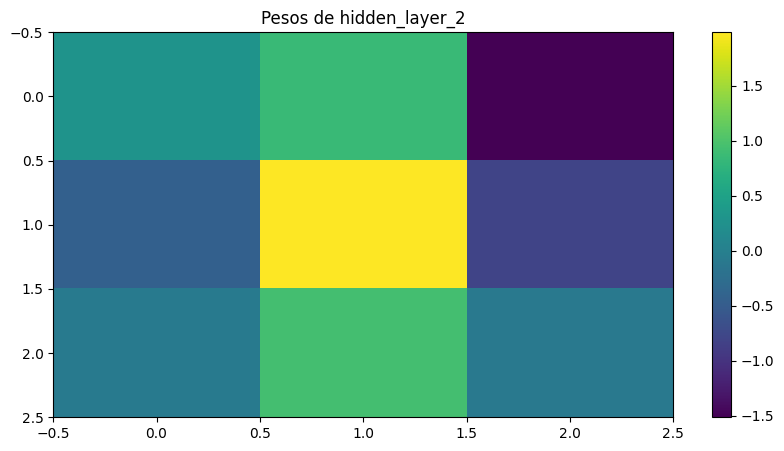

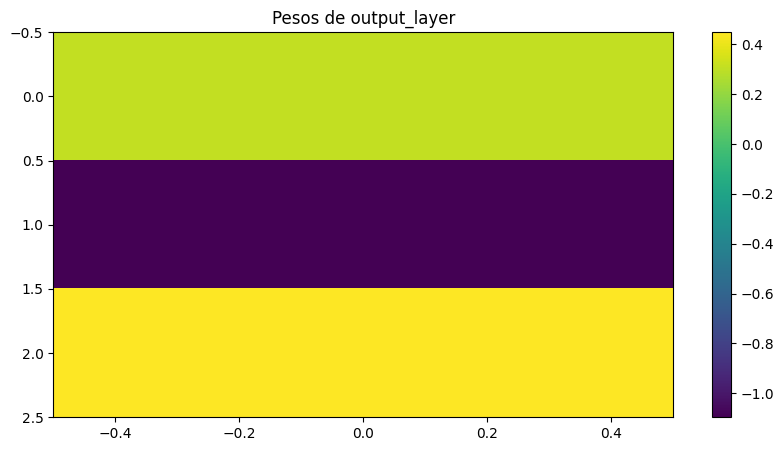

In [3]:
# Visualización de pesos y activaciones para la primera muestra de entrenamiento
sample_inputs, _ = train_data[0]
_, activations = forward(network, np.array(sample_inputs, ndmin=2))
plot_activations(activations)
plot_weights(network)

/usr/lib64/python3.11/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


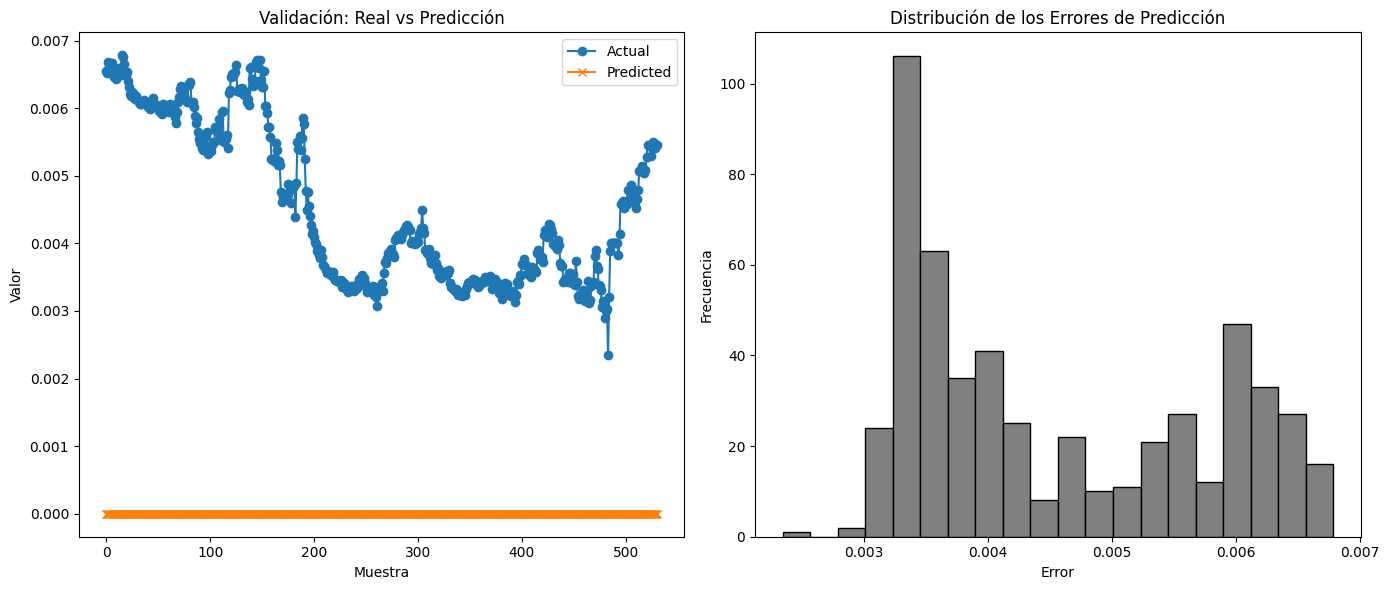

MAE: 0.0045, MSE: 0.0000, Correlación: nan
El precio de cierre predicho es: [[0.]]


In [4]:
# Validación de la red y visualización de resultados
validate_and_plot(network, valid_data)
test_input = np.array([40000, 41000, 39000]) / max_value
predicted_close_price = predict(network, test_input) * max_value
print(f"El precio de cierre predicho es: {predicted_close_price}")